In [47]:

import glob
import os.path
import numpy as np
import mne
import matplotlib.pyplot as plt
import pandas as pd
import yasa

import dataset

plt.style.use('default')
plt.rc('font', family='Arial')
plt.rc('axes', unicode_minus=False)

mne.set_log_level('CRITICAL')

In [48]:
df_info = dataset.load_info()

In [49]:
df_spikes = pd.read_excel(os.path.join(dataset.path['results'], 'spike_detect.xlsx'), index_col=0)
df_sessions = pd.read_excel(os.path.join(dataset.path['results'], 'sessions.xlsx'), index_col=0)

In [50]:
animals = df_sessions['animal_id'].unique()

In [51]:
def hist_bin(timestamp, bin_width=10, bin_step=5, max_len=None):
    if max_len is None:
        max_len = (timestamp.max() // bin_width) * (bin_width + 1)

    start = 0
    count = []
    start_points = []
    while start < max_len:
        end = start + bin_width
        count.append(((timestamp < end) & (timestamp >= start)).sum())
        start_points.append(start)
        start += bin_step

    return np.array(count) / bin_width, np.array(start_points)

In [52]:
def find_over_segs(data, thr, pad=0):
    def _find_terminals(bi_data):
        bi_data[0] = 0
        bi_data[-1] = 0
        bi_bad = np.diff(bi_data)
        bad_start_idx = np.argwhere(bi_bad == 1).reshape(-1)
        bad_end_idx = np.argwhere(bi_bad == -1).reshape(-1) + 1 

        return bad_start_idx, bad_end_idx

    flag_bad = np.abs(data) > thr * np.ones(shape=data.shape)
    bi_bad = np.zeros(shape=data.shape)
    bi_bad[flag_bad] = 1

    bad_start_idx, bad_end_idx = _find_terminals(bi_bad)

    if pad > 0:
        bad_start_idx = bad_start_idx - pad
        bad_end_idx = bad_end_idx + pad

        bad_start_idx[bad_start_idx < 0] = 0
        bad_end_idx[bad_end_idx > data.size] = data.size

        bi_bad = np.zeros(shape=data.shape)
        for (start_idx, end_idx) in zip(bad_start_idx, bad_end_idx):
            bi_bad[int(start_idx):int(end_idx)] = 1
            bad_start_idx, bad_end_idx = _find_terminals(bi_bad)

    return bad_start_idx, bad_end_idx, bi_bad

Text(0.5, 0, 'Time (s)')

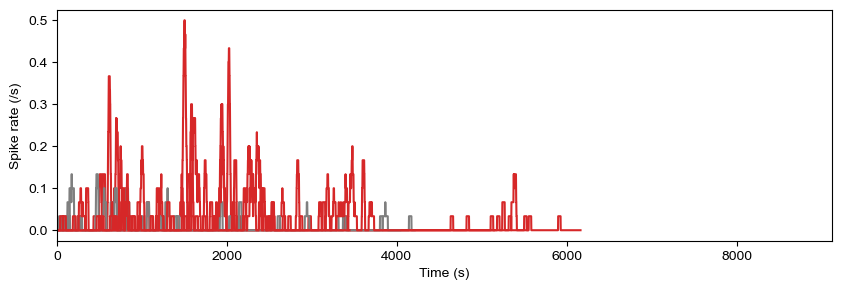

In [53]:
thr_sr = 0.1
bin_width = 30


plt.figure(figsize=(10, 3))

df_epi_period = pd.DataFrame()

for animal in animals:
    sessions = df_sessions.query('animal_id == @animal')['session'].unique()

    for session in sessions:

        df_spike_session = df_spikes.query('animal_id == @animal and session == @session')
        df_spike_session = df_spike_session.query('isi < 10 and isi > 0')
        df_spike_session = df_spike_session.reset_index(drop=True)

        if len(df_spike_session) == 0:
            spike_rate = 0
        else:
            session_length = df_spike_session['session_length'][0]
            
            sr, bin_edges = hist_bin(df_spike_session['peak_onset'], bin_width=bin_width, bin_step=1,
                                     max_len=session_length)
            if df_spike_session.loc[0, 'genotype'] == 'WT':
                color = 'tab:gray'
            else:
                color = 'tab:red'
            plt.plot(bin_edges, sr, color=color)

            if (sr > thr_sr).sum() == 0:
                spike_rate = 0
            else:
                spike_rate = sr[sr > thr_sr].mean()

            onsets, offsets, _ = find_over_segs(sr, thr_sr)
            if len(onsets) > 0:
                # spike rate in onset period
                sr_period = []
                for (on, off) in zip(onsets, offsets):
                    sr_period.append(
                        ((df_spike_session['peak_onset'] < off) & (df_spike_session['peak_onset'] >= on)).sum() / (
                                    off - on))

                # make table of onset period
                df_epi_onset_tmp = pd.DataFrame({'onsets': onsets, 'offsets': offsets, 'duration':offsets - onsets})
                df_epi_onset_tmp = pd.concat(
                    [pd.concat(
                        [df_sessions.query('animal_id == @animal and session == @session')] * len(df_epi_onset_tmp),
                        ignore_index=True), df_epi_onset_tmp],
                    axis=1
                )

                df_epi_onset_tmp['spike_rate'] = np.array(sr_period)
                df_epi_period = pd.concat([df_epi_period, df_epi_onset_tmp])
       
df_epi_period = df_epi_period.reset_index(drop=True)

plt.xlim(0, df_sessions['session_length'].max())
plt.ylabel('Spike rate (/s)')
plt.xlabel('Time (s)')

Sort the table.   

Delete segments shorter than the bin width. 

In [54]:
i = 0
while i < len(df_epi_period) - 1:
    if (
            (df_epi_period.loc[i + 1, 'onsets'] - df_epi_period.loc[i, 'offsets'] <= bin_width) and 
            (df_epi_period.loc[i + 1, 'animal_id'] == df_epi_period.loc[i, 'animal_id']) and 
            (df_epi_period.loc[i + 1, 'session'] == df_epi_period.loc[i, 'session'])
    ):
        spike_counts = (
                df_epi_period.loc[i + 1, 'spike_rate'] * df_epi_period.loc[i + 1, 'duration'] +
                df_epi_period.loc[i, 'spike_rate'] * df_epi_period.loc[i, 'duration']
        ) 
        
        df_epi_period.loc[i, 'offsets'] = df_epi_period.loc[i + 1, 'offsets']
        df_epi_period.loc[i, 'duration'] = df_epi_period.loc[i, 'offsets'] - df_epi_period.loc[i, 'onsets']
        df_epi_period.loc[i, 'spike_rate'] = spike_counts / df_epi_period.loc[i, 'duration']
        df_epi_period = df_epi_period.drop(i + 1)
        df_epi_period = df_epi_period.reset_index(drop=True)
    
    else:
        i += 1

df_epi_period = df_epi_period.query('duration >= @ bin_width')
df_epi_period = df_epi_period.reset_index(drop=True)
df_epi_period.to_excel(os.path.join(dataset.path['results'], 'epi_period.xlsx'))

In [55]:
df_epi_period

,animal_id,genotype,session,session_length,onsets,offsets,duration,spike_rate
0,0629#,Mutant,2024-03-09,2006.996,501,565,64,0.031250
1,0629#,Mutant,2024-03-09,2006.996,597,635,38,0.210526
2,0629#,Mutant,2024-03-09,2006.996,685,722,37,0.162162
3,0629#,Mutant,2024-03-09,2006.996,1474,1530,56,0.285714
4,0629#,Mutant,2024-03-09,2006.996,1565,1599,34,0.176471
5,0629#,Mutant,2024-03-09,2006.996,1916,1966,50,0.200000
6,0741#,Mutant,2024-03-14,2866.996,2003,2044,41,0.243902
7,0800#,Mutant,2024-04-18,3443.996,2240,2310,70,0.142857
8,0800#,Mutant,2024-04-18,3443.996,2341,2399,58,0.155172
9,0800#,Mutant,2024-05-14,6162.996,989,1020,31,0.129032


In [56]:
df_sessions.insert(df_sessions.shape[1], 'spike_rate', 0)
for animal in animals:
    sessions = df_sessions.query('animal_id == @animal')['session'].unique()

    for session in sessions:
        df_session_onset = df_epi_period.query("animal_id == @animal and session == @session")
        if len(df_session_onset) == 0:
            spike_rate_session = 0
        else:
            spike_rate_session = (
                (df_session_onset['spike_rate'] * df_session_onset['duration']).sum() / 
                df_session_onset['duration'].sum()
            )
            
        df_sessions.loc[df_sessions.query("animal_id == @animal and session == @session").index, 'spike_rate'] = spike_rate_session

C:\Users\60978\AppData\Local\Temp\ipykernel_21868\2321581495.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.17204301075268819' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_sessions.loc[df_sessions.query("animal_id == @animal and session == @session").index, 'spike_rate'] = spike_rate_session


In [57]:
df_sessions

,animal_id,genotype,session,session_length,spike_rate
0,0628#,WT,2024-03-14,2481.996,0.000000
1,0628#,WT,2024-04-07,4215.996,0.000000
2,0628#,WT,2024-05-27,7975.996,0.000000
3,0629#,Mutant,2024-03-09,2006.996,0.172043
4,0629#,Mutant,2024-03-29,3633.996,0.000000
5,0629#,Mutant,2024-04-22,3440.996,0.000000
6,0629#,Mutant,2024-05-15,7097.996,0.000000
7,0629#,Mutant,2024-05-29,5288.996,0.000000
8,0633#,WT,2024-03-09,2372.996,0.000000
9,0633#,WT,2024-03-28,3490.996,0.000000


Text(0, 0.5, 'Spike rate (/s)')

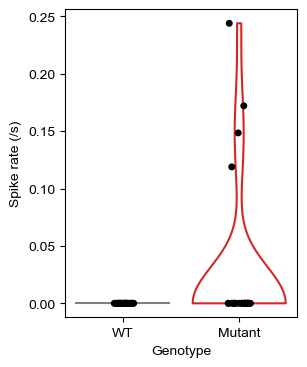

In [58]:
import seaborn as sns

plt.figure(figsize=(3, 4))
sns.violinplot(
    data=df_sessions,
    x='genotype',
    y='spike_rate',
    hue='genotype',
    hue_order=['WT', 'Mutant'],
    palette=['tab:gray', 'tab:red'],
    cut=0,
    fill=False
)

sns.stripplot(
    data=df_sessions,
    x='genotype',
    y='spike_rate',
    hue='genotype',
    hue_order=['WT', 'Mutant'],
    palette=['black', 'black']
)
plt.xlabel('Genotype')
plt.ylabel('Spike rate (/s)')

从现有criterion来说，有4个sessions包含了发作期。

In [59]:
from scipy.stats import levene, ttest_ind, ranksums

group_A = df_sessions.loc[df_sessions['genotype'] == 'WT', 'spike_rate']
group_B = df_sessions.loc[df_sessions['genotype'] == 'Mutant', 'spike_rate']
stat, p = ranksums(group_A, group_B)
print(f'P value: {p:.2f}')

P value: 0.37


# Statistics according epileptic onsets

In [93]:
df_psd = pd.DataFrame()
for i, row in df_sessions.iterrows():
    animal = row['animal_id']
    session = row['session']
    genotype = row['genotype']
    
    fname = os.path.join(dataset.path['tmp'], animal, session, 'raw_spike_detect.edf')
    raw = mne.io.read_raw_edf(fname, preload=True)
    sf = raw.info['sfreq']

    # drop bad epochs
    seg_duration = 2  # seconds
    n_seg = raw.times.shape[0] // (sf * seg_duration)  # assert number of seg more than time
    raw.crop(0, seg_duration * n_seg, include_tmax=False)
    raw.set_channel_types({'Loco': 'bio'})    
    
    epochs = mne.make_fixed_length_epochs(raw.copy(), duration=seg_duration, preload=True)
    epochs.drop_bad(flat=dict(eeg=5e-6))
    # epochs.plot_drop_log()
    
    # concatenate data
    raw_clean = raw.copy()
    raw_clean.filter(0.1, 40)
    data = raw_clean.get_data()
    data = data.reshape(2, len(epochs.drop_log), -1)
    flag = np.ones(len(epochs.drop_log), dtype='bool')
    flag[epochs.selection] = False
    data[0, flag, :] = np.nan
    data = data.reshape(2, -1)
    
    raw_clean._data = data * 1e6    
    raw_clean = raw_clean.pick([raw.ch_names[0]])
    psd = raw_clean.compute_psd(fmax=40, method='welch', n_fft=1000, n_overlap=100, n_per_seg=500)
    df = psd.to_data_frame()
    
    if row['spike_rate'] == 0:
        if genotype == 'WT':
            group = 'WT-rest'
        else:
            group = 'Mutant-rest'
    else:
        group = 'Mutant-onset'
        
    df['genotype'] = genotype
    df['group'] = group
        
    df_psd = pd.concat([df_psd, df], ignore_index=True)  
        
    

In [94]:
eeg_ch_name = raw.ch_names[0]
df_psd[eeg_ch_name] = 10 * np.log10(df_psd[eeg_ch_name])

In [95]:
from scipy.stats import ttest_ind, levene
from statsmodels.stats.multitest import fdrcorrection

pvalues = np.zeros(psd.freqs.shape[0])
for i, freq in enumerate(psd.freqs):
    A = df_psd.loc[df_psd.query("freq == @freq and group == 'WT-rest'").index, eeg_ch_name]
    B = df_psd.loc[df_psd.query("freq == @freq and group == 'Mutant-onset'").index, eeg_ch_name]
    
    _, p_square = levene(A, B)
    res = ttest_ind(A, B, equal_var=p_square > 0.05)
    pvalues[i] = res.pvalue
    
rejected, pvalues_fdr = fdrcorrection(pvalues) 

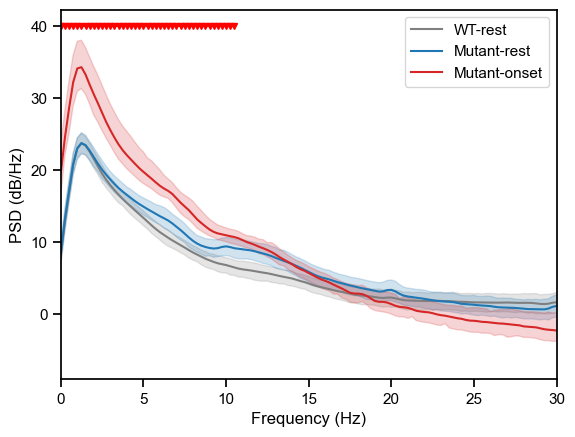

In [99]:
import seaborn as sns

sns.set_context('notebook')
sns.lineplot(
    x="freq",
    y=eeg_ch_name,
    hue="group",
    hue_order=['WT-rest', 'Mutant-rest', 'Mutant-onset'],
    palette=['tab:gray', 'tab:blue','tab:red'],
    data=df_psd
)
pvalues_plot = np.zeros(psd.freqs.shape[0])
pvalues_plot[:] = np.nan
pvalues_plot[pvalues_fdr < 0.05] = 40
plt.plot(psd.freqs, pvalues_plot, 'red', marker='v', markersize=5)
plt.ylabel('PSD (dB/Hz)')
plt.xlabel('Frequency (Hz)')
plt.xlim([0, 30])
plt.legend(title=None)
plt.show()